# Import Files, Model and Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Images
!cp -R drive/My\ Drive/Stylist/test/content /content/
!cp -R drive/My\ Drive/Stylist/test/style /content/
!cp -R drive/My\ Drive/Stylist/test/mask /content/
# Model
!cp drive/My\ Drive/Stylist/model/human_512-5++.hdf5 /content/
!cp drive/My\ Drive/Stylist/modely.py /content/
# Style Transfer
!cp drive/My\ Drive/Stylist/style_transfer.py /content/

In [3]:
!ls

content  human_512-5++.hdf5  modely.py	  sample_data  style_transfer.py
drive	 mask		     __pycache__  style


In [4]:
from keras.models import load_model
from modely import *
from style_transfer import *
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
model = load_model("human_512-5++.hdf5", custom_objects={"awesomeq_loss" : awesomeq_loss, 'dice_loss':dice_loss})

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Apply Portrait Segmentation

In [0]:
def load_image(path, size=512, isImg = False):
    if isImg:
        imgx = path
    else:
        imgx = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB).astype(np.uint8)

    img  = imgx.copy().astype(np.uint8)
    imgx,pad,signal = padding(resize_image(imgx, size),size,3, True)
    img  = padding(resize_image(img, size),size,3).astype(np.float64)
    img /= 255.0
    img = np.expand_dims(img, axis =0)
    return imgx,img, pad,signal

def fill_holes(im_in):
    # Read image

    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.

    th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);

    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th.astype(np.int) | im_floodfill_inv.astype(np.int)

    return im_out


def potrait_extract(model,path, isImg = False,isRGB= False):
    if isImg == False:
        imgx = cv2.imread(path)#,cv2.COLOR_BGR2RGB)
    else:
        imgx = path
    img,img_pre,pad,signal = load_image(path,512, isImg)
    
    pred = model.predict(img_pre)
    mask = np.squeeze(pred) * 255.0
    mask[ mask >128] = 255
    mask[ mask <= 128 ] = 0
    if signal == 2:
        new_mask = cv2.resize(mask[:,pad:-pad], (imgx.shape[1], imgx.shape[0]))
    elif signal == 1:
        new_mask = cv2.resize(mask[pad:-pad,:], (imgx.shape[1], imgx.shape[0]))
    else:
        new_mask = cv2.resize(mask, (imgx.shape[1], imgx.shape[0]))
    new_mask[ new_mask > 128] = 255
    new_mask[ new_mask <= 128 ] = 0
    imgx[ new_mask != 255 ] = 255
    if  isRGB:
        return cv2.cvtColor(imgx,cv2.COLOR_BGR2RGB)
    else:
        return imgx

# Local Style Transfer
Applies style transfer to given image with given mask image. If mask_path is None, then it applies portrait segmentation.

In [0]:
def local_style_transfer(content_path, style_path, inside, mask_path=None, smooth=False):
  content = cv2.cvtColor(cv2.imread(content_path), cv2.COLOR_BGR2RGB)
  style = cv2.cvtColor(cv2.imread(style_path), cv2.COLOR_BGR2RGB)
  
  style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
  content_layer = 'block2_conv2'

  stylized = transfer_style(content.shape[1], content.shape[0], style_layers, content_layer, content_path, style_path, content_weight = 0.1, style_weight = 10.0, total_variation_weight = 1.5)
  stylized = np.array(stylized)
  
  if mask_path is None:
    mask = potrait_extract(model, content_path, False, True)
  else:
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
  
  result = content.copy()
  if inside:
    result[mask<250] = stylized[mask<250]
  else:
    result[mask>250] = stylized[mask>250]
  
  # Smoothing
  if smooth:
    kernel = np.ones((5,5),np.float32)/25
    result = cv2.filter2D(result,-1,kernel)
    
  return result

# Example Run

Start of iteration 1
Current loss value: 509429380000.0
Iteration 1 completed in 45s

Start of iteration 2
Current loss value: 386329400000.0
Iteration 2 completed in 28s

Start of iteration 3
Current loss value: 349456830000.0
Iteration 3 completed in 29s

Start of iteration 4
Current loss value: 331974900000.0
Iteration 4 completed in 29s

Start of iteration 5
Current loss value: 321762000000.0
Iteration 5 completed in 29s

Start of iteration 6
Current loss value: 315727280000.0
Iteration 6 completed in 30s

Start of iteration 7
Current loss value: 312115070000.0
Iteration 7 completed in 29s

Start of iteration 8
Current loss value: 309886550000.0
Iteration 8 completed in 29s

Start of iteration 9
Current loss value: 308324340000.0
Iteration 9 completed in 30s

Start of iteration 10
Current loss value: 307225600000.0
Iteration 10 completed in 30s



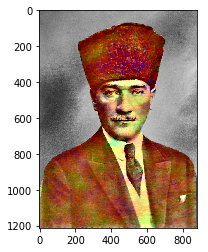

In [7]:
# Choose the images that you want to test from folders
content_path = "/content/content/portrait_2.jpg"
style_path = "/content/style/style_4.jpg"
mask_path = "/content/mask/mask_2.jpg"

result = local_style_transfer(content_path, style_path, True, mask_path=None)
plt.imshow(result)